In [1]:
import sys
from gene_cv import *
from scap import Scap
import numpy as np
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.externals import joblib
import glob
import pickle
import os
import pandas
import matplotlib.pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
directory = '/cluster/u/kjag/splicing_classifier/results/mutpred/'
region = 'Exonic'
p_file, b_file = directory+"hg19.pathogenicv2.features."+region.replace(" ", "_")+".tsv", directory+"hg19.allgnomad.features."+region.replace(" ", "_")+".tsv"
p, b = pickle.load(open(p_file, "rb")), pickle.load(open(b_file, "rb"))

In [3]:
var_time = {}
timestamp_filename = directory + 'hgmd_timestamp.txt'
f = open(timestamp_filename, 'r')
"""
format:
chrom	pos	ref	alt	id	time
3	164777814	A	G	BM0042985	2000
"""
for line in f:
    info = line.strip().split('\t')
    chrom, pos, ref, alt, time = info[0], info[1], info[2], info[3], info[5]
    var_time[(chrom, pos, ref, alt)] = time

In [4]:
times = []
for index, var in p.iterrows():
    key = (str(var['CHROM']), str(var['POS']), str(var['REF']), str(var['ALT']))
    if key in var_time.keys():
        times.append(int(var_time[key]))
    else:
        times.append(int(-1))
        
p['time'] = pandas.Series(times, index=p.index)

In [5]:
p_train = p[p['time'] <= 2012]
p_test = p[p['time'] > 2012]
per80 = int(len(b)*.8)
b_train = b.iloc[:per80]
b_test = b.iloc[-(len(b)-per80):]

In [6]:
p_train.shape, p_test.shape, b_train.shape, b_test.shape

((216, 140), (78, 140), (40000, 139), (10000, 139))

/cluster/u/kjag/anaconda2/lib/python2.7/site-packages/matplotlib/figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


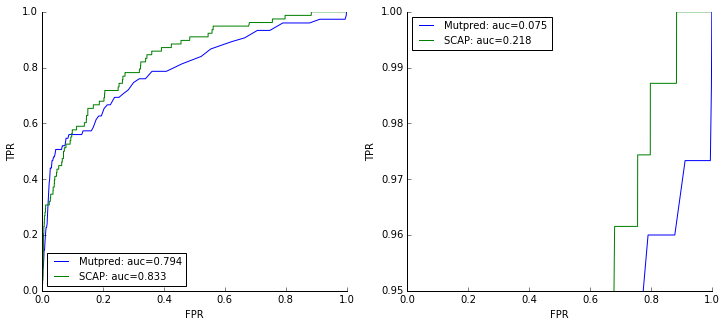

In [7]:
fig = plt.figure(1, figsize=(12, 5))
roc = fig.add_subplot(1, 2, 1)
hs_roc = fig.add_subplot(1, 2, 2)

mutpred = []
true_class = []
mut_scores = open(directory + 'mutpred_scores.txt')
for line in mut_scores:
    mutpred.append(float(line.strip()))
true_class = [1] * len(p_test)
true_class.extend(([0] * len(b_test)))

true_class = [true_class[y] for y in range(len(mutpred)) if mutpred[y] != float('inf')]
mutpred = [mutpred[y] for y in range(len(mutpred)) if mutpred[y] != float('inf')]

fpr, tpr, thresh = roc_curve(true_class, mutpred)
roc.plot(fpr, tpr, label = 'Mutpred: auc={0:.3f}'.format(auc(fpr, tpr)))
hs_roc.plot(fpr, tpr, label = 'Mutpred: auc={0:.3f}'.format(20*(auc(fpr, tpr)-auc(fpr, map(lambda x: min([x, .95]), tpr)))))

from scap import Scap
from chromosome_cv import *

clfs = {'SCAP'      : GradientBoostingClassifier()}

BLOCKED = ['CHROM', 'REF', 'ALT', 'POS', 'strand',
           'Exon_pos', 'total', 'ALFQMAX', 'gnomad_alfq', 'gnomad_hmfq',
           "HMFQMAX", "HMCTMAX","ALCTMAX","HMCTMAX",
           'gene_common_name', 'exon_name', 'BP_SCORE',
           'RefCryptDiffThreeNOFS', 'RefCryptDiffThreeFS',
           'RefCryptDiffFiveFS', 'RefCryptDiffFiveNOFS'
           'MaxEntScanAltFive', 'MaxEntScanDiffFive',
           'MaxEntScanAltThree', 'MaxEntScanDiffThree',
           'DOM', "EIGEN", "EIGEN_NONCODING", "time"]

features = features_from_blocked(p_train, BLOCKED)

p_train1 = featurize(p_train, features)
b_train1 = featurize(b_train, features)
train_ex = np.vstack((p_train1, b_train1))

p_test1 = featurize(p_test, features)
b_test1 = featurize(b_test, features)
test_ex = np.vstack((p_test1, b_test1))

train_class = [1] * len(p_train)
train_class.extend(([0] * len(b_train)))

test_class = [1] * len(p_test)
test_class.extend(([0] * len(b_test)))

m = GradientBoostingClassifier().fit(train_ex, train_class)
probs = m.predict_proba(test_ex)
fpr, tpr, thresh = roc_curve(test_class, probs[:,1])
roc.plot(fpr, tpr, label = 'SCAP: auc={0:.3f}'.format(auc(fpr, tpr)))
hs_roc.plot(fpr, tpr, label = 'SCAP: auc={0:.3f}'.format(20*(auc(fpr, tpr)-auc(fpr, map(lambda x: min([x, .95]), tpr)))))

roc.set_ylabel('TPR')
roc.set_xlabel('FPR')
roc.legend(loc='best', fontsize='medium')
roc.spines['right'].set_visible(False)
roc.spines['top'].set_visible(False)
roc.yaxis.set_ticks_position('left')
roc.xaxis.set_ticks_position('bottom')

hs_roc.set_ylabel('TPR')
hs_roc.set_xlabel('FPR')
hs_roc.legend(loc='best', fontsize='medium')
hs_roc.set_ylim(0.95, 1.0)
hs_roc.spines['right'].set_visible(False)
hs_roc.spines['top'].set_visible(False)
hs_roc.yaxis.set_ticks_position('left')
hs_roc.xaxis.set_ticks_position('bottom')

fig.show()